fold_1

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [2]:
print("Train set:  ", len(os.listdir("../fold_1/train_image_dir")))
print("Train masks:", len(os.listdir("../fold_1/train_mask_dir")))

Train set:   1430
Train masks: 1430


In [3]:
patient_ids = []
paths = []
for dirname, _, filenames in os.walk('../fold_1/train_image_dir'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        patient_id = filename.split(".")[0]
        patient_ids.append(patient_id)

d = {"id": patient_ids, "patient_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

,patient_path
id,
100_1,../fold_1/train_image_dir\100_1.jpg
100_10,../fold_1/train_image_dir\100_10.jpg
100_11,../fold_1/train_image_dir\100_11.jpg
100_12,../fold_1/train_image_dir\100_12.jpg
100_13,../fold_1/train_image_dir\100_13.jpg
...,...
99_5,../fold_1/train_image_dir\99_5.jpg
99_6,../fold_1/train_image_dir\99_6.jpg
99_7,../fold_1/train_image_dir\99_7.jpg


In [4]:
patient_ids = []
mask_path = []
for dirname, _, filenames in os.walk('../fold_1/train_mask_dir'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        patient_id = filename.split(".")[0]
        patient_id = patient_id.split("_HGE_Seg")[0]
        patient_ids.append(patient_id)

        
d = {"id": patient_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

,mask_path
id,
100_10,../fold_1/train_mask_dir\100_10_HGE_Seg.jpg
100_11,../fold_1/train_mask_dir\100_11_HGE_Seg.jpg
100_12,../fold_1/train_mask_dir\100_12_HGE_Seg.jpg
100_13,../fold_1/train_mask_dir\100_13_HGE_Seg.jpg
100_14,../fold_1/train_mask_dir\100_14_HGE_Seg.jpg
...,...
99_5,../fold_1/train_mask_dir\99_5_HGE_Seg.jpg
99_6,../fold_1/train_mask_dir\99_6_HGE_Seg.jpg
99_7,../fold_1/train_mask_dir\99_7_HGE_Seg.jpg


In [5]:
df["mask_path"] = mask_df["mask_path"]
df

,patient_path,mask_path
id,,
100_1,../fold_1/train_image_dir\100_1.jpg,../fold_1/train_mask_dir\100_1_HGE_Seg.jpg
100_10,../fold_1/train_image_dir\100_10.jpg,../fold_1/train_mask_dir\100_10_HGE_Seg.jpg
100_11,../fold_1/train_image_dir\100_11.jpg,../fold_1/train_mask_dir\100_11_HGE_Seg.jpg
100_12,../fold_1/train_image_dir\100_12.jpg,../fold_1/train_mask_dir\100_12_HGE_Seg.jpg
100_13,../fold_1/train_image_dir\100_13.jpg,../fold_1/train_mask_dir\100_13_HGE_Seg.jpg
...,...,...
99_5,../fold_1/train_image_dir\99_5.jpg,../fold_1/train_mask_dir\99_5_HGE_Seg.jpg
99_6,../fold_1/train_image_dir\99_6.jpg,../fold_1/train_mask_dir\99_6_HGE_Seg.jpg
99_7,../fold_1/train_image_dir\99_7.jpg,../fold_1/train_mask_dir\99_7_HGE_Seg.jpg


In [6]:
img_size = [256,256]

def data_augmentation(patient_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        patient_img = tf.image.flip_left_right(patient_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return patient_img, mask_img

def preprocessing(patient_path, mask_path):
    patient_img = tf.io.read_file(patient_path) 
    patient_img = tf.image.decode_jpeg(patient_img, channels=3)
    patient_img = tf.image.resize(patient_img, img_size)
    patient_img = tf.cast(patient_img, tf.float32) / 255.0
    patient_img = float(patient_img);
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    mask_img = float(mask_img)    
    
    return patient_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["patient_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["patient_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [7]:
from keras.preprocessing import image

In [8]:
#importing the libraries
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)


In [10]:
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [11]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 32

BUFFER_SIZE = 1000

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3


In [12]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

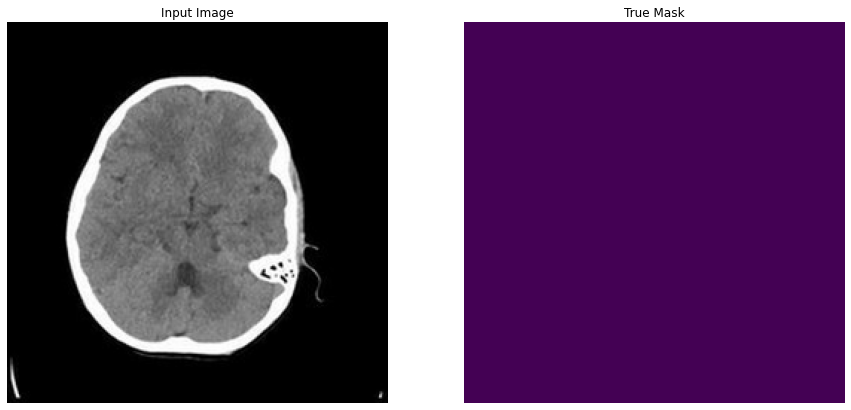

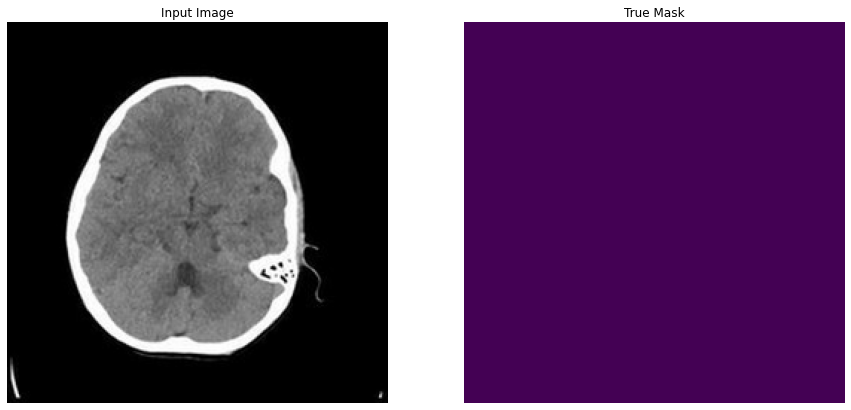

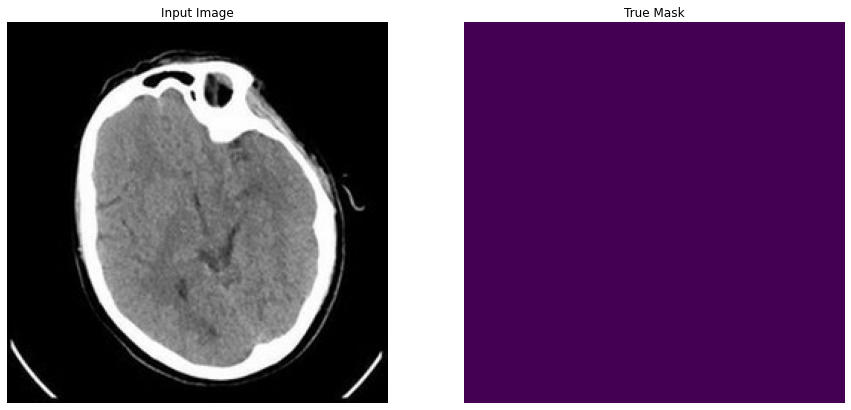

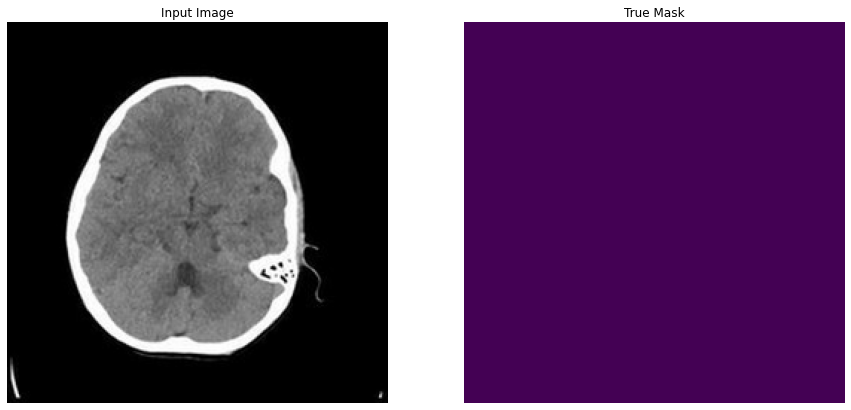

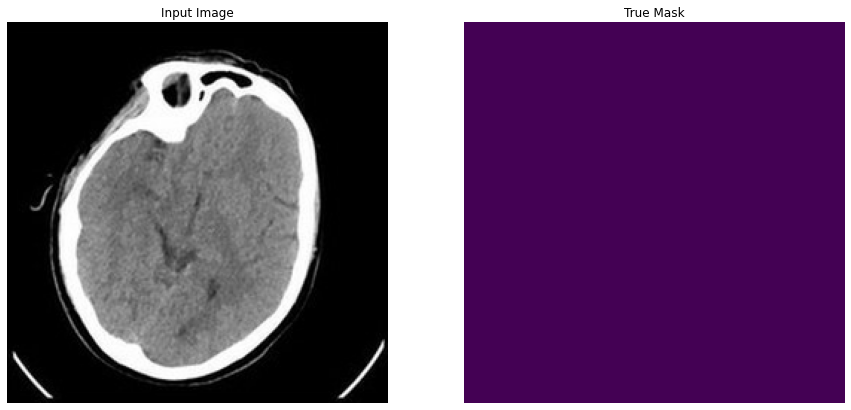

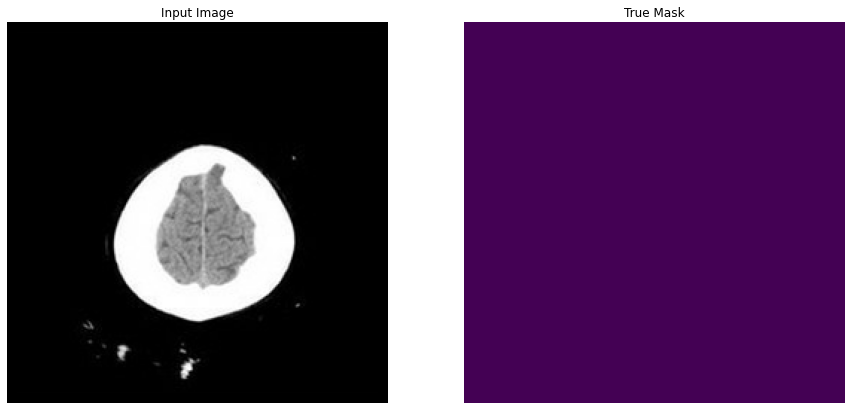

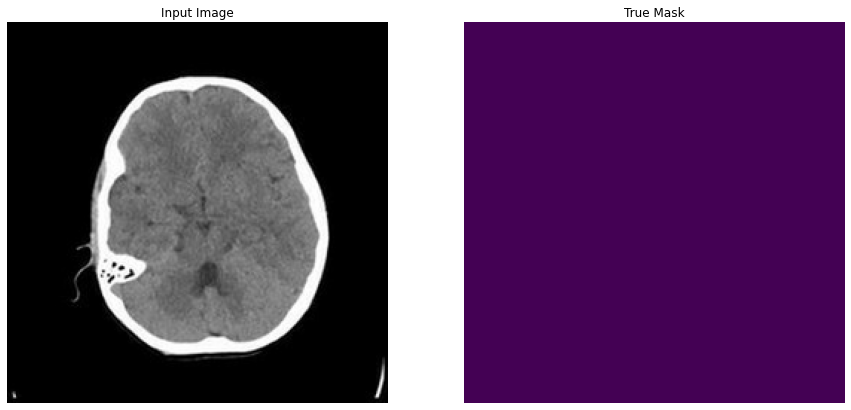

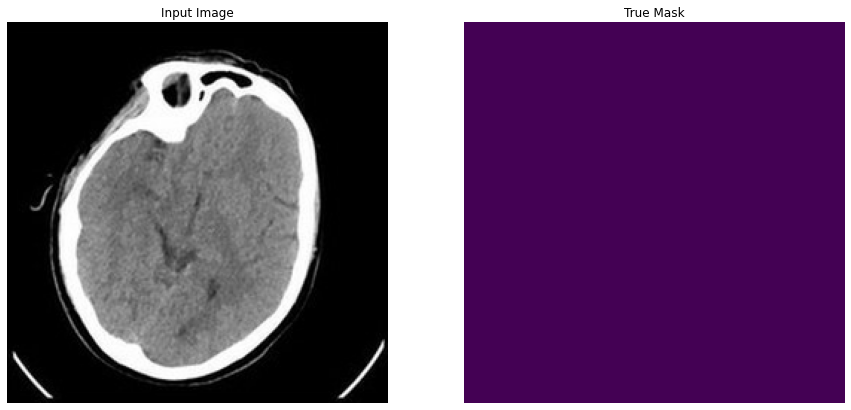

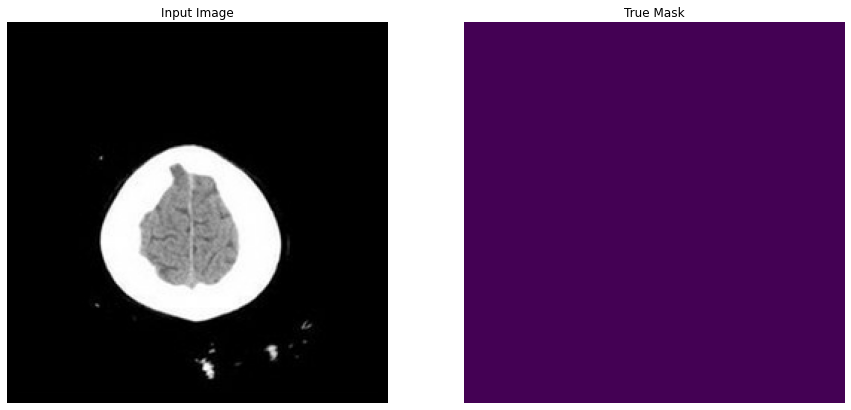

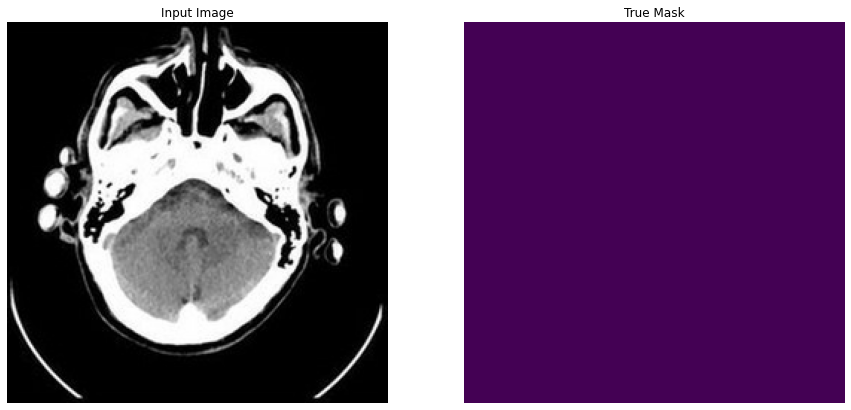

In [14]:
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

Model

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [16]:
def fcn(image_size, ch_in=3, ch_out=3):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [17]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [18]:
# calling the model inside the scope
with strategy.scope():
  model = fcn(image_size=(256, 256))
  # compiling the model with the optimizer, loss function and acc metrics
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
!pip install pydot

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [21]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

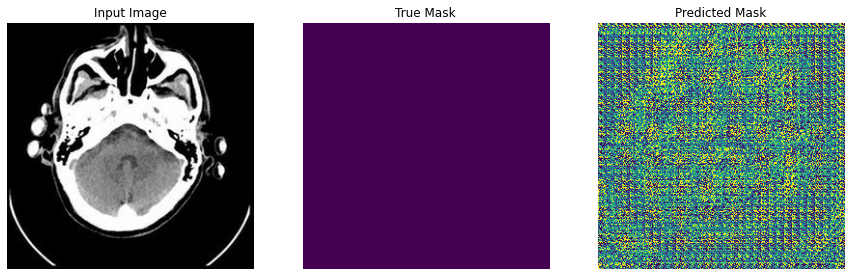

In [23]:
# Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions()

In [24]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

In [25]:
valid_dataset = valid.batch(BATCH_SIZE)
val_length = len(valid_df)
TRAIN_LENGTH = len(train_df)

In [26]:
EPOCHS = 10

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping])

Epoch 1/10
27/33 [=======================>......] - ETA: 3:54 - loss: 0.6902 - accuracy: 0.7171

In [1]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD

from swa.keras import SWA

# make dataset
X, y = make_blobs(n_samples=1000, 
                  centers=3, 
                  n_features=2, 
                  cluster_std=2, 
                  random_state=2)

y = to_categorical(y)

# build model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(learning_rate=0.1))

epochs = 100
start_epoch = 75

# define swa callback
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr=0.001,
          swa_lr2=0.003,
          swa_freq=3,
          batch_size=32, # needed when using batch norm
          verbose=1)

# train
model.fit(X, y, batch_size=32, epochs=epochs, verbose=1, callbacks=[swa])

ImportError: cannot import name 'to_categorical' from 'keras.utils' (E:\miniconda\lib\site-packages\keras\utils\__init__.py)